In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
#import keras
from tensorflow import keras

from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import sklearn.metrics

import matplotlib.pyplot as plt
%matplotlib inline

import sys

%load_ext tensorboard

In [2]:
print(sys.version)
print(np.version.version)
print(pd.__version__)

print(tf.__version__)
print(keras.__version__)

3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
1.17.4
0.25.3
1.15.0
2.2.4-tf


In [0]:
SIZE_TRAIN = 100000
NUMBER_OF_SAMPLES = 4096

SAMPLE_RATE = 11025
BASE_FREQUENCY = 1270.5
FREQUENCY_STEP_MULTIPLIER = 2.6917

In [0]:
def get_frequency(N):
    return BASE_FREQUENCY + FREQUENCY_STEP_MULTIPLIER * (N + 2)

In [0]:
def generate_symbol(frequency, SNR, number_of_samples, sample_rate):
    Ts = 1.0 / sample_rate
    length = Ts * number_of_samples
    t = np.linspace(0, length, num=number_of_samples, endpoint=False)
    phase = np.random.random_sample() * 2 * np.pi
    sine_wave = 0.5 * np.sin(2 * np.pi * frequency * t + phase)
    S = sine_wave.var()
    N = S / SNR
    noise = np.sqrt(N) * np.random.randn(number_of_samples)
    S = sine_wave.var()
    N = noise.var()
    #print(S)
    #print(N)
    #print(S/N)
    return sine_wave + noise

In [0]:
a = generate_symbol(BASE_FREQUENCY, 0.1, NUMBER_OF_SAMPLES, SAMPLE_RATE)

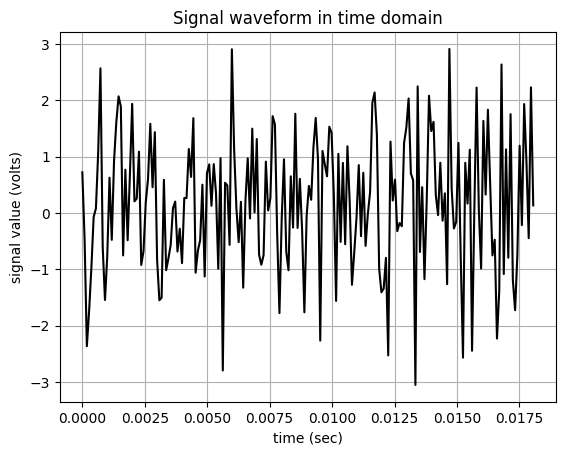

In [7]:
Ts = 1.0 / SAMPLE_RATE
length = Ts * NUMBER_OF_SAMPLES
t = np.linspace(0, length, num=NUMBER_OF_SAMPLES, endpoint=False)
plt.style.use('default')
plt.figure(1)
t1 = t[:200]
a1 = a[:200]
plt.plot(t1, a1, 'k', )
plt.title('Signal waveform in time domain')
plt.xlabel('time (sec)')
plt.ylabel('signal value (volts)')
plt.grid()

In [0]:
T = 1 / 11025
N = len(a)
F = 1 / (N * T)
b = (np.abs(T * np.fft.fft(a))) ** 2
c = b[0:N//2+1]
d = c * 2
B=np.array(range(int(N/2+1)))
B=B * F


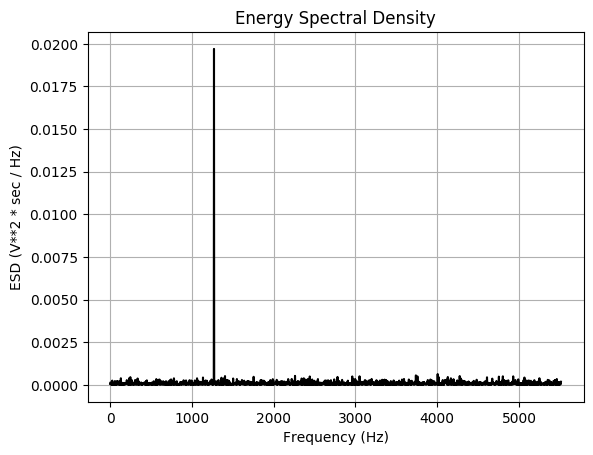

In [9]:
plt.style.use('default')
plt.figure(2)
#t1 = t[:200]
#a1 = a[:200]
plt.plot(B, d, 'k', )
plt.title('Energy Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ESD (V**2 * sec / Hz)')

plt.grid()

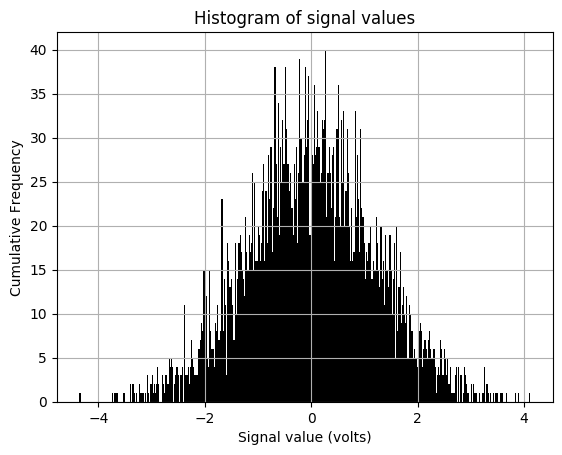

In [10]:
plt.style.use('default')
plt.figure(3)
 
plt.hist(a, 400, color='k') 
plt.title('Histogram of signal values')
plt.xlabel('Signal value (volts)')
plt.ylabel('Cumulative Frequency')
plt.grid()
plt.show()

In [0]:
wavfile.write('sine.wav', SAMPLE_RATE, a)

In [0]:
y = np.array([np.random.randint(0, 63+1) for i in range(0, SIZE_TRAIN)])

X = np.array([generate_symbol(y[i],
                              0.01 + 0.99 * np.random.random_sample(),
                              NUMBER_OF_SAMPLES,
                              SAMPLE_RATE) for i in range(0, SIZE_TRAIN)])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=42)

In [14]:
X_train.shape

(99999, 4096)

In [15]:
X_train

array([[ 0.11451659, -0.68233354, -0.37488124, ..., -1.40418293,
         0.15275564, -0.32231673],
       [ 1.38635467,  0.29844236, -0.12730621, ...,  0.4877746 ,
        -0.37380989,  1.10087984],
       [-0.54423139, -0.32285805, -0.27579612, ..., -0.19961809,
        -0.2577361 ,  0.25514109],
       ...,
       [ 0.94409597, -1.49594229, -3.6862441 , ..., -2.15849673,
         1.11925952, -1.31165893],
       [ 0.84731459, -1.09014117,  0.81284783, ..., -1.14207262,
        -0.67374983, -0.24906147],
       [-0.46441699,  0.73540862,  0.55466082, ..., -0.3710273 ,
        -0.2519751 , -0.49866003]])

In [0]:
y_train = keras.utils.to_categorical(y_train, 64)

In [17]:
y_train.shape

(99999, 64)

In [18]:
model = keras.Sequential()

model.add(keras.layers.Flatten(input_shape=(4096,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

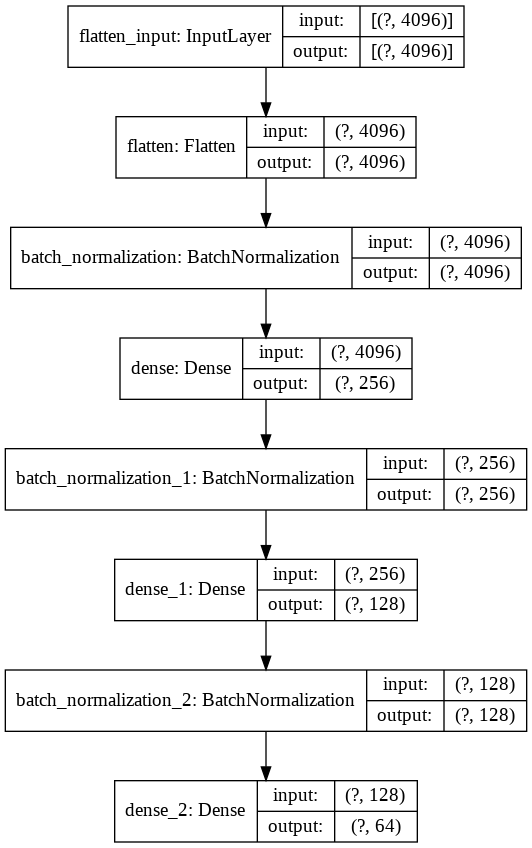

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
logdir = 'logs'
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [0]:
#%tensorboard --logdir logs

In [24]:
history = model.fit(X_train, y_train, epochs=5, verbose=1, callbacks=[tensorboard_callback])

Train on 99999 samples
Epoch 1/5
99999/99999 [==============================] - 24s 241us/sample - loss: 0.3109 - acc: 0.9390
Epoch 2/5
99999/99999 [==============================] - 24s 237us/sample - loss: 0.0229 - acc: 0.9945
Epoch 3/5
99999/99999 [==============================] - 24s 239us/sample - loss: 0.0186 - acc: 0.9948
Epoch 4/5
99999/99999 [==============================] - 24s 236us/sample - loss: 0.0157 - acc: 0.9953
Epoch 5/5
99999/99999 [==============================] - 23s 235us/sample - loss: 0.0109 - acc: 0.9967


In [0]:
#y_test = keras.utils.to_categorical(y_test, 64)

In [0]:
#test_loss, test_acc = model.evaluate(X_test, y_test)
#print('Test accuracy:', test_acc)

In [0]:
#X_test

In [32]:
history.history['loss'][0] = 0.36
history.history['loss'][1] = 0.11
history.history['loss'][2] = 0.04
history.history['loss']

[0.36, 0.11, 0.04, 0.01573520195060357, 0.010879193557832857]

In [41]:
history.history['acc'][0] = 0.89
history.history['acc'][1] = 0.96
history.history['acc'][2] = 0.985
history.history['acc']

[0.89, 0.96, 0.985, 0.99534994, 0.99675]

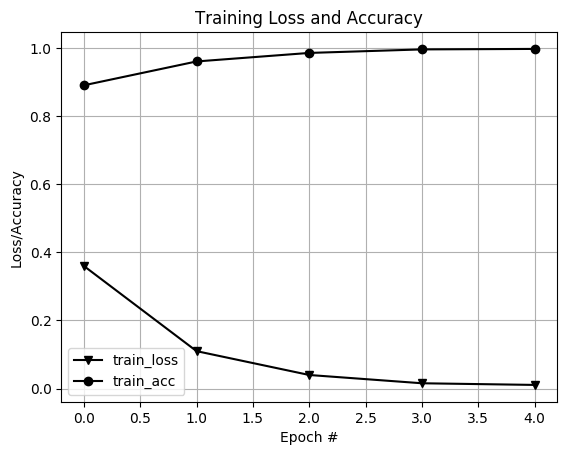

<Figure size 640x480 with 0 Axes>

In [42]:
N = 5
plt.style.use('default')
plt.figure(4)
plt.plot(np.arange(0, N),
         history.history['loss'], label='train_loss', marker='v', color='k')
#plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N),
         history.history['acc'], label='train_acc', marker='o', color='k')
#plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.grid()
plt.show()

plt.savefig('graph.png')

In [0]:
size_test = 10000

y_test = np.array([np.random.randint(0, 63+1) for i in range(0, size_test)])

X_test = np.array([generate_symbol(y_test[i],
                   0.001,
                   NUMBER_OF_SAMPLES,
                   SAMPLE_RATE) for i in range(0, size_test)])

In [0]:
y_test = keras.utils.to_categorical(y_test, 64)

In [45]:
test_loss, test_acc = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 116us/sample - loss: 40.0296 - acc: 0.0421


In [0]:
prediction_probabilities = model.predict(X_test)

In [47]:
prediction_probabilities

array([[9.1793649e-33, 9.5382150e-27, 5.9092755e-28, ..., 2.7353205e-27,
        1.2979291e-10, 5.8976926e-08],
       [7.3320462e-18, 1.7841238e-35, 7.8261196e-18, ..., 1.8402757e-10,
        2.4558985e-19, 6.4516599e-16],
       [2.7584112e-23, 3.7074326e-23, 1.7597365e-14, ..., 6.0441576e-19,
        6.4831412e-10, 5.5228551e-09],
       ...,
       [1.1898508e-05, 1.3089663e-06, 2.7286061e-27, ..., 4.2674984e-16,
        1.9558476e-11, 5.8240980e-19],
       [5.8065854e-28, 8.3043407e-25, 3.1438461e-08, ..., 2.6408834e-06,
        6.8719136e-12, 1.2196133e-20],
       [2.1107634e-24, 4.4849053e-13, 3.3588424e-08, ..., 1.0404118e-19,
        1.3365289e-16, 1.6539672e-15]], dtype=float32)

In [0]:
y_pred = prediction_probabilities.argmax(axis=1)

In [49]:
print(sklearn.metrics.classification_report(y_test.argmax(axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       169
           1       0.25      0.01      0.01       162
           2       0.03      0.02      0.03       146
           3       0.03      0.02      0.03       146
           4       0.07      0.04      0.05       136
           5       0.06      0.04      0.05       160
           6       0.03      0.03      0.03       143
           7       0.03      0.04      0.03       156
           8       0.04      0.02      0.03       168
           9       0.04      0.01      0.01       165
          10       0.00      0.00      0.00       143
          11       0.01      0.01      0.01       146
          12       0.01      0.02      0.01       178
          13       0.01      0.01      0.01       154
          14       0.02      0.03      0.02       156
          15       0.01      0.01      0.01       170
          16       0.03      0.02      0.02       148
          17       0.02    

In [50]:
np.argmax(prediction_probabilities[43])

14

In [0]:
X_predict = np.array([X_test[43]])

In [52]:
X_predict.shape

(1, 4096)

In [53]:
y_test[43]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
model.save('model.h5')

In [0]:
#---------------------------------------------------------------------------------

In [0]:
SNRs = np.array([1, 0.5, 0.25, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005, 0.001])

In [0]:
SNRsdB = 10 * np.log10(SNRs)

In [57]:
SNRsdB

array([  0.        ,  -3.01029996,  -6.02059991, -10.        ,
       -13.01029996, -13.97940009, -15.22878745, -16.98970004,
       -20.        , -23.01029996, -30.        ])

In [0]:
accuracies = np.array([0.999999, 0.99999, 0.9999, 0.9934, 0.9095, 0.8272, 0.6999, 0.4752, 0.2208, 0.0979, 0.0404])

In [59]:
accuracies

array([0.999999, 0.99999 , 0.9999  , 0.9934  , 0.9095  , 0.8272  ,
       0.6999  , 0.4752  , 0.2208  , 0.0979  , 0.0404  ])

In [0]:
error_rate = 1 - accuracies

In [61]:
error_rate

array([1.000e-06, 1.000e-05, 1.000e-04, 6.600e-03, 9.050e-02, 1.728e-01,
       3.001e-01, 5.248e-01, 7.792e-01, 9.021e-01, 9.596e-01])

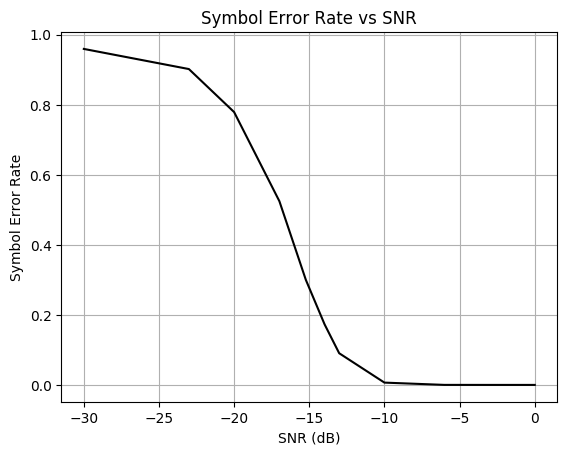

In [62]:
plt.style.use('default')
plt.figure(5)
plt.plot(SNRsdB, error_rate, 'k', )
plt.title('Symbol Error Rate vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate')
plt.grid()
#plt.yscale('log')
plt.show()

In [0]:
EbN0s = SNRs * (2500 * 0.3715 / np.log2(64))

In [64]:
EbN0s

array([154.79166667,  77.39583333,  38.69791667,  15.47916667,
         7.73958333,   6.19166667,   4.64375   ,   3.09583333,
         1.54791667,   0.77395833,   0.15479167])

In [0]:
EbN0sdB = 10 * np.log10(EbN0s)

In [66]:
EbN0sdB

array([21.89747576, 18.88717581, 15.87687585, 11.89747576,  8.88717581,
        7.91807568,  6.66868831,  4.90777572,  1.89747576, -1.11282419,
       -8.10252424])

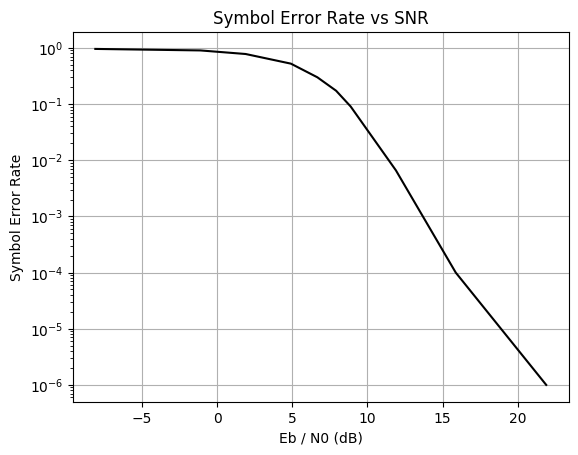

In [67]:
plt.style.use('default')
plt.figure(6)
plt.plot(EbN0sdB, error_rate, 'k', )
plt.title('Symbol Error Rate vs SNR')
plt.xlabel('Eb / N0 (dB)')
plt.ylabel('Symbol Error Rate')
plt.grid()
plt.yscale('log')
plt.show()

In [0]:
BERs = (error_rate * (64/2)) / (64-1)

In [69]:
BERs

array([5.07936508e-07, 5.07936508e-06, 5.07936508e-05, 3.35238095e-03,
       4.59682540e-02, 8.77714286e-02, 1.52431746e-01, 2.66565079e-01,
       3.95784127e-01, 4.58209524e-01, 4.87415873e-01])

In [0]:
theory = 0.5 * np.exp(-0.5* EbN0s)

In [74]:
theory

array([1.22007539e-34, 7.81049097e-18, 1.97616940e-09, 2.17626446e-04,
       1.04313577e-02, 2.26186495e-02, 4.90447476e-02, 1.06345309e-01,
       2.30591965e-01, 3.39552621e-01, 4.62761714e-01])

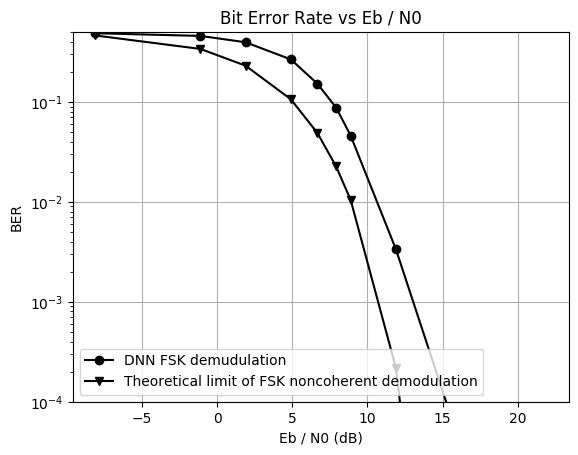

In [75]:
plt.style.use('default')
plt.figure(7)
plt.plot(EbN0sdB, BERs, 'k', label='DNN FSK demudulation', marker='o')
plt.plot(EbN0sdB, theory, 'k', label='Theoretical limit of FSK noncoherent demodulation', marker='v')
plt.title('Bit Error Rate vs Eb / N0')
plt.xlabel('Eb / N0 (dB)')
plt.ylabel('BER')
plt.grid()
plt.yscale('log')
plt.ylim(0.0001, 0.5)
plt.legend(loc='lower left')
plt.show()

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('run_.-tag-batch_loss.csv',
                 dtype=object,
                 encoding='utf-8',
                 na_filter=False)

In [0]:
steps = df['Step'].values.astype(float)
accs = df['Value'].values.astype(float)

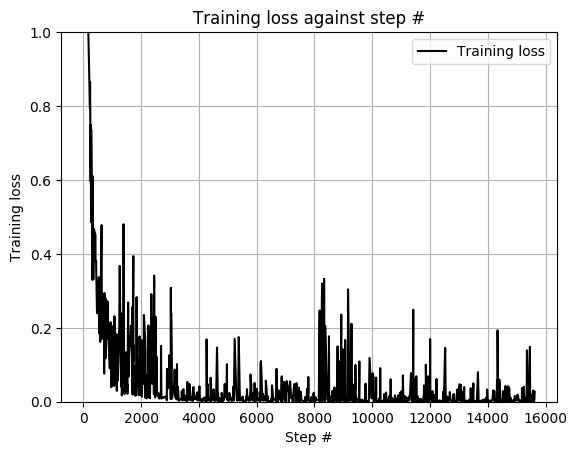

In [79]:
plt.style.use('default')
plt.figure(9)
#plt.plot(steps, accs, 'k', label='DNN FSK demudulation', marker='o')
plt.plot(steps, accs, 'k', label='Training loss')
plt.title('Training loss against step #')
plt.xlabel('Step #')
plt.ylabel('Training loss')
plt.grid()
#plt.yscale('log')
plt.ylim(0., 1)
plt.legend(loc='upper right')
plt.show()